# 도축개월 28~35

In [1]:
import pandas as pd
import numpy as np
import math
import os
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
from matplotlib import font_manager, rc
font_path= 'C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

##### Data import

In [3]:
df = pd.read_excel('도축예측모델 검증 리스트-암소전체-230526-키우소.xlsx')
df.head()

,우시장 암소,도축개월령,암소 생시체중,농가번호,도축 형매수,형매 도체중 평균,형매 등심단면적 평균,형매 등지방 평균,형매 근내지방도 평균,부KPN 개월별 근내지방도 평균,농가 도축소 근내지방도 평균,도축소 근내지방도,Probability
0,2159437849,28,624,410188,0,0.0,0.0,0.0,0.0,6.57,6.00,6,NaN
1,2154149276,31,665,466490,0,0.0,0.0,0.0,0.0,6.50,0.00,4,NaN
2,2155409528,33,596,444538,4,343.5,69.0,10.5,4.5,6.49,5.75,9,NaN
3,2154224882,33,635,462483,0,0.0,0.0,0.0,0.0,6.41,0.00,5,NaN
4,2155249844,32,658,471725,1,351.0,90.0,14.0,4.0,6.38,0.00,7,NaN


##### 도축개월 28~35개월임을 확인

In [4]:
df.describe()

,우시장 암소,도축개월령,암소 생시체중,농가번호,도축 형매수,형매 도체중 평균,형매 등심단면적 평균,형매 등지방 평균,형매 근내지방도 평균,부KPN 개월별 근내지방도 평균,농가 도축소 근내지방도 평균,도축소 근내지방도,Probability
count,7.940000e+02,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.00000,794.000000,0.0
mean,2.154011e+09,32.401763,633.328715,316547.950882,0.700252,134.041209,29.494270,4.144207,1.700605,4.990705,3.07665,4.749370,NaN
std,2.883963e+06,2.124391,66.771119,135205.768178,1.335640,198.145208,43.506286,6.464474,2.669521,0.602637,2.54946,1.929111,NaN
min,2.142767e+09,28.000000,361.000000,18048.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.200000,0.00000,1.000000,NaN
25%,2.152203e+09,31.000000,588.000000,180095.750000,0.000000,0.000000,0.000000,0.000000,0.000000,4.570000,0.00000,3.000000,NaN
50%,2.153915e+09,33.000000,630.000000,351326.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.015000,4.00000,5.000000,NaN
75%,2.155733e+09,34.000000,674.000000,448313.000000,1.000000,381.627500,84.627500,10.000000,4.000000,5.390000,5.20000,6.000000,NaN
max,2.166287e+09,35.000000,890.000000,475431.000000,8.000000,572.000000,135.000000,29.000000,9.000000,6.570000,9.00000,9.000000,NaN


#### 계산기 만들기

In [5]:
df_copy = df.copy()
df_copy.head()

,우시장 암소,도축개월령,암소 생시체중,농가번호,도축 형매수,형매 도체중 평균,형매 등심단면적 평균,형매 등지방 평균,형매 근내지방도 평균,부KPN 개월별 근내지방도 평균,농가 도축소 근내지방도 평균,도축소 근내지방도,Probability
0,2159437849,28,624,410188,0,0.0,0.0,0.0,0.0,6.57,6.00,6,NaN
1,2154149276,31,665,466490,0,0.0,0.0,0.0,0.0,6.50,0.00,4,NaN
2,2155409528,33,596,444538,4,343.5,69.0,10.5,4.5,6.49,5.75,9,NaN
3,2154224882,33,635,462483,0,0.0,0.0,0.0,0.0,6.41,0.00,5,NaN
4,2155249844,32,658,471725,1,351.0,90.0,14.0,4.0,6.38,0.00,7,NaN


##### TARGET1(789) 확률계산

In [6]:
# 농장 등급 만들기
df_copy['농장등급A'] = df_copy['농가 도축소 근내지방도 평균'].apply(lambda x: 1 if 7 <= x <=9 else 0)
df_copy['농장등급B'] = df_copy['농가 도축소 근내지방도 평균'].apply(lambda x: 1 if 4 <= x < 7 else 0)
print(f"농가등급A개수:{df_copy['농장등급A'].value_counts()}")
print('\n')
print(f"농가등급B개수:{df_copy['농장등급B'].value_counts()}")

농가등급A개수:농장등급A
0    772
1     22
Name: count, dtype: int64


농가등급B개수:농장등급B
0    404
1    390
Name: count, dtype: int64


In [7]:
# 확인
print(f"농가등급7이상:{len(df_copy[df_copy['농가 도축소 근내지방도 평균']>=7])}")
print(f"농가등급4이상7미만:{len(df_copy[(df_copy['농가 도축소 근내지방도 평균']<7)&(4<= df_copy['농가 도축소 근내지방도 평균'])])}")

농가등급7이상:22
농가등급4이상7미만:390


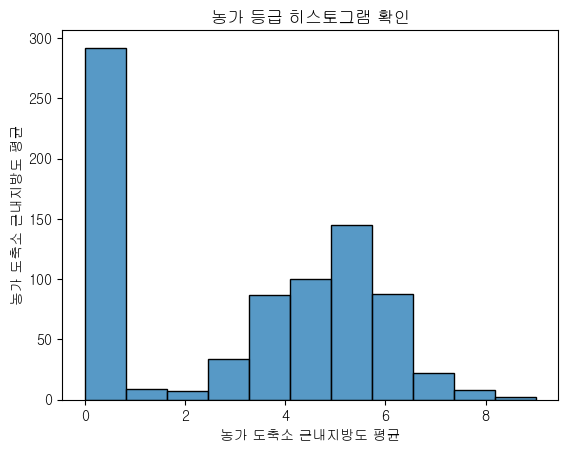

In [8]:
# 농가등급 A가 거의 없다.. 확인
sns.histplot(df_copy['농가 도축소 근내지방도 평균'])

plt.ylabel('농가 도축소 근내지방도 평균')
plt.title('농가 등급 히스토그램 확인')
plt.show()

In [9]:
df_copy.columns

Index(['우시장 암소', '도축개월령', '암소 생시체중', '농가번호', '도축 형매수', '형매 도체중 평균',
       '형매 등심단면적 평균', '형매 등지방 평균', '형매 근내지방도 평균', '부KPN 개월별 근내지방도 평균',
       '농가 도축소 근내지방도 평균', '도축소 근내지방도', 'Probability', '농장등급A', '농장등급B'],
      dtype='object')

###### 반복문사용해서 만들기

In [10]:
for index, row in df_copy.iterrows():
    x = (-6.9333 - 0.0667 + (1.257*row['농장등급A'])
         + (-0.2926*row['농장등급B']) + (0.0234*row['도축개월령'])
         + (0.00567*(row['암소 생시체중']-269))
         + (-0.0023*row['형매 도체중 평균'])
         + (0.00162*row['형매 등심단면적 평균'])
         + (-0.0087*row['형매 등지방 평균'])
         + (0.1816*row['형매 근내지방도 평균'])
         + (0.0129*row['도축 형매수'])
         + (0.613*row['부KPN 개월별 근내지방도 평균']))
    probability = np.exp(x) / (1 + np.exp(x))
    df_copy.loc[index, 'Probability'] = probability

# 결과 출력
# 도축개월 조정 확률계산기를 이용해 Probability가 일치함을 확인
df_copy.tail()

,우시장 암소,도축개월령,암소 생시체중,농가번호,도축 형매수,형매 도체중 평균,형매 등심단면적 평균,형매 등지방 평균,형매 근내지방도 평균,부KPN 개월별 근내지방도 평균,농가 도축소 근내지방도 평균,도축소 근내지방도,Probability,농장등급A,농장등급B
789,2153095125,33,658,311867,0,0.0,0.0,0.0,0.0,3.52,0.00,3,0.134190,0,0
790,2157236986,33,588,471726,0,0.0,0.0,0.0,0.0,3.41,0.00,3,0.088771,0,0
791,2155650857,33,587,141909,0,0.0,0.0,0.0,0.0,3.41,2.79,2,0.088313,0,0
792,2153729235,33,648,141447,1,439.0,82.0,13.0,2.0,3.41,5.92,6,0.052401,0,1
793,2152532574,34,633,109023,2,354.0,80.0,11.0,4.0,3.20,5.30,2,0.075885,0,1


In [11]:
df_copy['Probability'].describe()

count    794.000000
mean       0.246492
std        0.117207
min        0.048534
25%        0.166589
50%        0.224078
75%        0.299775
max        0.811090
Name: Probability, dtype: float64

##### TARGET1 PERFORMANCE

In [12]:
df_copy['TARGET1'] = df_copy['도축소 근내지방도'].apply(lambda x: 1 if 7 <= x <=9 else 0)
df_copy['Prob_5'] = df_copy['Probability'].apply(lambda x: 1 if 0.5 <= x else 0)
df_copy['Prob_6'] = df_copy['Probability'].apply(lambda x: 1 if 0.6 <= x else 0)
df_copy['Prob_7'] = df_copy['Probability'].apply(lambda x: 1 if 0.7 <= x else 0)
df_copy['Prob_8'] = df_copy['Probability'].apply(lambda x: 1 if 0.8 <= x else 0)
df_copy['Prob_9'] = df_copy['Probability'].apply(lambda x: 1 if 0.9 <= x else 0)

###### 변수변환 및 확인

In [13]:
print(f"7이상개수:{len(df_copy[df_copy['도축소 근내지방도']>=7])}")
print(f"TARGET1개수:{len(df_copy[df_copy['TARGET1']==1])}")
print('========================================='*2)
print(f"0.5이상개수:{len(df_copy[df_copy['Probability']>=0.5])}")
print(f"Prob_5개수:{len(df_copy[df_copy['Prob_5']==1])}")
print('========================================='*2)
print(f"0.6이상개수:{len(df_copy[df_copy['Probability']>=0.6])}")
print(f"Prob_6개수:{len(df_copy[df_copy['Prob_6']==1])}")
print('========================================='*2)
print(f"0.7이상개수:{len(df_copy[df_copy['Probability']>=0.7])}")
print(f"Prob_7개수:{len(df_copy[df_copy['Prob_7']==1])}")
print('========================================='*2)
print(f"0.8이상개수:{len(df_copy[df_copy['Probability']>=0.8])}")
print(f"Prob_8개수:{len(df_copy[df_copy['Prob_8']==1])}")
print('========================================='*2)
print(f"0.9이상개수:{len(df_copy[df_copy['Probability']>=0.9])}")
print(f"Prob_9개수:{len(df_copy[df_copy['Prob_9']==1])}")

7이상개수:111
TARGET1개수:111
0.5이상개수:28
Prob_5개수:28
0.6이상개수:15
Prob_6개수:15
0.7이상개수:8
Prob_7개수:8
0.8이상개수:1
Prob_8개수:1
0.9이상개수:0
Prob_9개수:0


##### PERFORMANCE CHECK

###### performance 측정 함수 정의

In [14]:
def performance(TP,TN,FP,FN):
    
    N = TP+TN+FP+FN
    
    Sensitivity=(TP/(TP+FN))*100
    Sensitivity_l=(Sensitivity/100-1.96*math.sqrt( (Sensitivity/100)*(1-(Sensitivity/100))/(TP+FN) ) )*100
    Sensitivity_u=(Sensitivity/100+1.96*math.sqrt( (Sensitivity/100)*(1-(Sensitivity/100))/(TP+FN) ) )*100

    Specificity=(1-FP/(TN+FP))*100
    Specificity_l=(Specificity/100-1.96*math.sqrt( (Specificity/100)*(1-(Specificity/100))/(FP+TN) ) )*100
    Specificity_u=(Specificity/100+1.96*math.sqrt( (Specificity/100)*(1-(Specificity/100))/(FP+TN) ) )*100

    Accuracy=((TP+TN)/(TP+TN+FP+FN))*100
    Accuracy_l=(Accuracy/100-1.96*math.sqrt( (Accuracy/100)*(1-(Accuracy/100))/N ) )*100
    Accuracy_u=(Accuracy/100+1.96*math.sqrt( (Accuracy/100)*(1-(Accuracy/100))/N ) )*100

    PPV= (TP/(TP+FP))*100 
    PPV_l=(PPV/100-1.96*math.sqrt( (PPV/100)*(1-(PPV/100))/(TP+FP) ) )*100
    PPV_u=(PPV/100+1.96*math.sqrt( (PPV/100)*(1-(PPV/100))/(TP+FP) ) )*100

    NPV= (TN/(TN+FN))*100 
    NPV_l=(NPV/100-1.96*math.sqrt( (NPV/100)*(1-(NPV/100))/(TN+FN) ) )*100
    NPV_u=(NPV/100+1.96*math.sqrt( (NPV/100)*(1-(NPV/100))/(TN+FN) ) )*100
    
    result = {
        'Metric': ['Sensitivity', 'Specificity', 'Accuracy', 'PPV', 'NPV'],
        'Value': [Sensitivity, Specificity, Accuracy, PPV, NPV],
        'CI_Lower': [Sensitivity_l, Specificity_l, Accuracy_l, PPV_l, NPV_l],
        'CI_Upper': [Sensitivity_u, Specificity_u, Accuracy_u, PPV_u, NPV_u]
    }
    
    result_2 = pd.DataFrame(result)
    
    return result_2

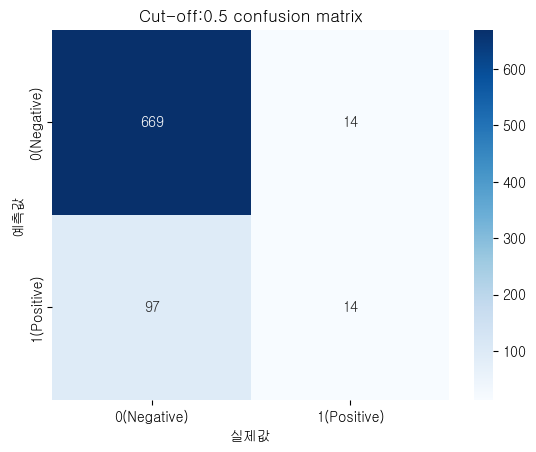

,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,50.000000,31.479741,68.520259
1,Specificity,87.336815,84.981701,89.691928
2,Accuracy,86.020151,83.608041,88.432261
3,PPV,12.612613,6.436411,18.788815
4,NPV,97.950220,96.887541,99.012899


In [25]:
# cut-off 0.5
cm = confusion_matrix(df_copy['TARGET1'], df_copy['Prob_5'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.5 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

performance(14,669,97,14)

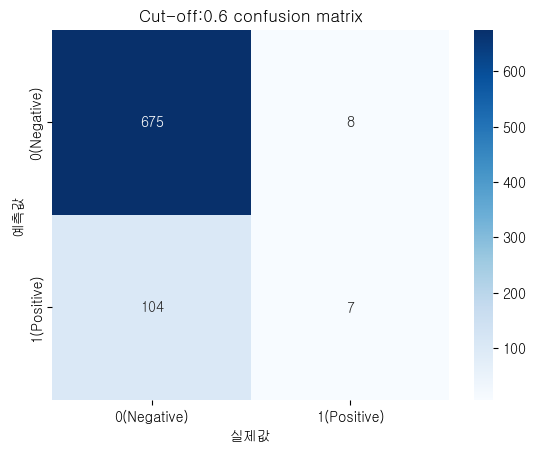

,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,46.666667,21.419468,71.913865
1,Specificity,86.649551,84.261088,89.038013
2,Accuracy,85.894207,83.473030,88.315383
3,PPV,6.306306,1.784236,10.828376
4,NPV,98.828697,98.021793,99.635601


In [24]:
# cut-off 0.6
cm = confusion_matrix(df_copy['TARGET1'], df_copy['Prob_6'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.6 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

performance(7,675,104,8)

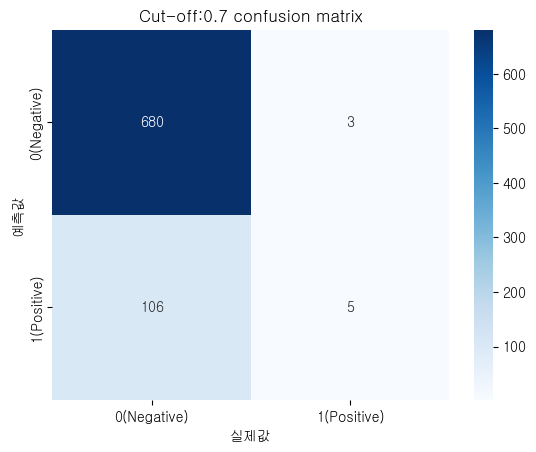

,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,62.500000,28.951993,96.048007
1,Specificity,86.513995,84.126021,88.901969
2,Accuracy,86.272040,83.878262,88.665818
3,PPV,4.504505,0.646084,8.362925
4,NPV,99.560761,99.064809,100.056714


In [23]:
# cut-off 0.7
cm = confusion_matrix(df_copy['TARGET1'], df_copy['Prob_7'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.7 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

performance(5,680,106,3)

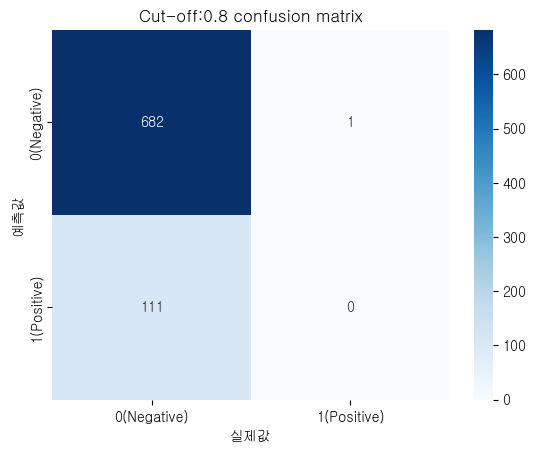

,Metric,Value,CI_Lower,CI_Upper
0,Sensitivity,0.000000,0.000000,0.000000
1,Specificity,86.002522,83.587618,88.417427
2,Accuracy,85.894207,83.473030,88.315383
3,PPV,0.000000,0.000000,0.000000
4,NPV,99.853587,99.566828,100.140346


In [22]:
# cut-off 0.8
cm = confusion_matrix(df_copy['TARGET1'], df_copy['Prob_8'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('Cut-off:0.8 confusion matrix')
plt.xticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.yticks([0.5,1.5],['0(Negative)','1(Positive)'])
plt.show()

performance(0,682,111,1)

In [21]:
df_copy.to_excel('TARGET1_예측결과.xlsx', index=False)